## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:
- test rmse: 44798.497576784845
- test r2: 0.7079639526659389

To beat my model you will need a test r2 bigger than 0.71 and a rmse smaller than 44798.


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge

Remember that you need to fork this repo first, upload your winning notebook to your repo, and then make a PR (pull request) to my repo. I will then revise and accept the PR, which will appear in my repo and be available to all the students in the course. This way, other students can learn from your creativity when transforming the variables in your dataset. 

## House Prices dataset

In [418]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler

### Load Datasets

In [419]:
# load dataset

data = pd.read_csv('../houseprice.csv')

In [420]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [421]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 14 discrete variables
There are 4 temporal variables
There are 43 categorical variables


### Separate train and test set

In [373]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [374]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [375]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [376]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

## Feature Engineering Pipeline

In [377]:
data.shape

(1460, 81)

In [378]:
missing_data = data.isnull().sum()
missing_data[missing_data > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [379]:
removed_variables = ['Alley', 'PoolQC', 'MiscFeature', 'Fence' ]
X_train = X_train.drop(columns = removed_variables)
X_test = X_test.drop(columns = removed_variables)

I choose the median to fill the missing data because it is less sensitive to outliers if they are any that we will spot afterwards

In [380]:
def impute_na(X_train, X_test, variable):
    median = X_train[variable].median()
    X_train[variable].fillna(median, inplace = True)
    X_test[variable].fillna(median, inplace = True)

In [381]:
for num_variable in numerical + year_vars:
    if num_variable != 'YrSold':
        impute_na(X_train, X_test, num_variable)

In [382]:
def impute_na_cat(X_train, X_test, variable):
    mode = X_train[variable].mode()
    X_train[variable].fillna(mode.values[0], inplace = True)
    X_test[variable].fillna(mode.values[0], inplace = True)


In [383]:
for cat_variable in discrete + categorical :
    if cat_variable not in removed_variables:
        impute_na_cat(X_train, X_test,  cat_variable)

We drop 4 columns

In [384]:
# reasonable amount of categories
for cat_variable in discrete + categorical:
    if cat_variable not in removed_variables:
        print('Number of categories in the variable Name: {}'.format(
            len(X_train[cat_variable].unique())))

Number of categories in the variable Name: 15
Number of categories in the variable Name: 10
Number of categories in the variable Name: 9
Number of categories in the variable Name: 4
Number of categories in the variable Name: 3
Number of categories in the variable Name: 4
Number of categories in the variable Name: 3
Number of categories in the variable Name: 8
Number of categories in the variable Name: 4
Number of categories in the variable Name: 12
Number of categories in the variable Name: 4
Number of categories in the variable Name: 5
Number of categories in the variable Name: 7
Number of categories in the variable Name: 12
Number of categories in the variable Name: 5
Number of categories in the variable Name: 2
Number of categories in the variable Name: 4
Number of categories in the variable Name: 4
Number of categories in the variable Name: 2
Number of categories in the variable Name: 5
Number of categories in the variable Name: 3
Number of categories in the variable Name: 25
Numbe

In [385]:
## functions to encode rare categories
def find_non_rare_labels(df, variable, tolerance):
    
    temp = df.groupby([variable])[variable].count()/len(df)
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]
    
    return non_rare

def rare_encoding(X_train, X_test, variable, tolerance):

    X_train = X_train.copy()
    X_test = X_test.copy()

    # find the most frequent category
    frequent_cat = find_non_rare_labels(X_train, variable, tolerance)

    # re-group rare labels
    X_train[variable] = np.where(X_train[variable].isin(
        frequent_cat), X_train[variable], 'Rare')
    
    X_test[variable] = np.where(X_test[variable].isin(
        frequent_cat), X_test[variable], 'Rare')

    return X_train, X_test

## encoding rare categories
for var in categorical:
    if var not in ['Alley', 'PoolQC', 'MiscFeature', 'Fence' ]:
        train_encoded, test_encoded = rare_encoding(X_train, X_test, var, 0.1)

In [386]:
for nom_var in categorical:
    if nom_var not in ['Alley', 'PoolQC', 'MiscFeature', 'Fence' ]:
        count_map = train_encoded[nom_var].value_counts().to_dict()
        # replace the labels with the counts
        train_encoded[nom_var] = train_encoded[nom_var].map(count_map)
        test_encoded[nom_var] = test_encoded[nom_var].map(count_map)


In [405]:
from sklearn.preprocessing import KBinsDiscretizer

disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

disc.fit(train_encoded[numerical+discrete+ ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']])

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')

In [406]:
train_t = disc.transform(train_encoded[numerical+discrete+ ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']])

train_encoded = pd.DataFrame(train_t, columns = numerical+discrete+ ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'])

train_encoded.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,PoolArea,MoSold,YearBuilt,YearRemodAdd,GarageYrBlt
0,1.0,0.0,0.0,0.0,0.0,6.0,2.0,2.0,0.0,0.0,...,3.0,3.0,4.0,0.0,7.0,0.0,5.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,3.0,3.0,2.0,0.0,2.0,0.0,6.0,3.0,0.0,4.0
2,1.0,0.0,2.0,0.0,0.0,6.0,2.0,3.0,0.0,0.0,...,2.0,3.0,3.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,...,3.0,3.0,2.0,3.0,5.0,0.0,6.0,0.0,1.0,0.0
4,2.0,0.0,1.0,0.0,0.0,4.0,2.0,2.0,0.0,0.0,...,3.0,3.0,4.0,3.0,5.0,0.0,5.0,3.0,7.0,4.0


In [407]:
test_t = disc.transform(test_encoded[numerical+discrete+ ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']])

test_encoded = pd.DataFrame(test_t, columns = numerical+discrete+ ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'])

test_encoded.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,PoolArea,MoSold,YearBuilt,YearRemodAdd,GarageYrBlt
0,1.0,1.0,0.0,2.0,0.0,3.0,3.0,5.0,0.0,0.0,...,5.0,6.0,5.0,6.0,5.0,0.0,1.0,3.0,5.0,2.0
1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0,...,3.0,3.0,2.0,6.0,2.0,0.0,6.0,4.0,9.0,6.0
2,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,...,3.0,3.0,2.0,3.0,2.0,0.0,5.0,4.0,9.0,5.0
3,2.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,4.0,0.0,...,5.0,3.0,5.0,3.0,5.0,0.0,1.0,2.0,5.0,2.0
4,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,...,3.0,3.0,3.0,0.0,2.0,0.0,1.0,2.0,6.0,3.0


In [359]:
# train_encoded =  X_train
# for nom_var in categorical:
#     if nom_var not in ['Alley', 'PoolQC', 'MiscFeature', 'Fence' ]:
#         train_encoded = pd.get_dummies(train_encoded, columns=[nom_var])

In [360]:
# test_encoded =  X_test
# for nom_var in categorical:
#     if nom_var not in ['Alley', 'PoolQC', 'MiscFeature', 'Fence' ]:
#         test_encoded = pd.get_dummies(test_encoded, columns=[nom_var])

In [408]:
train_encoded.shape

(1314, 35)

In [409]:
# Columns in the test set and not in the train set
test_encoded.columns.difference(train_encoded.columns)

# Columns in the train set and not in the test set
train_encoded.columns.difference(test_encoded.columns)

# We delete the columns which are in the test set but not in the train set 
test_encoded = test_encoded.drop(set(test_encoded.columns) - set(train_encoded.columns), axis=1)

In [410]:
# Now, we want to add the columns which are in the train set but not in the test set
def add_missing_dummy_columns(df1, df2):
    """add missing columns to df2 from df1"""
    missing_cols = set(df1.columns) - set(df2.columns)    
    for row in missing_cols:
        df2[row] = 0

add_missing_dummy_columns(train_encoded, test_encoded)

# We check if we have the same number of columns
assert(train_encoded.shape[1]== test_encoded.shape[1])

In [411]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# standardisation: with the StandardScaler from sklearn

# set up the scaler 
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(train_encoded)

# transform train and test sets
train_encoded_scaled  = scaler.transform(train_encoded)
test_encoded_scaled = scaler.transform(test_encoded)

In [412]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha= 0.5, random_state=0)

In [413]:
# let's fit the pipeline
clf.fit(train_encoded_scaled, y_train)

# let's get the predictions
X_train_preds = clf.predict(train_encoded_scaled)
X_test_preds = clf.predict(test_encoded_scaled)

In [414]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 1200056659.2940776
train rmse: 34641.83394819157
train r2: 0.8078012536186417

test mse: 1768821636.5875378
test rmse: 42057.36126515236
test r2: 0.742608852906797


Text(0, 0.5, 'Predicted Price')

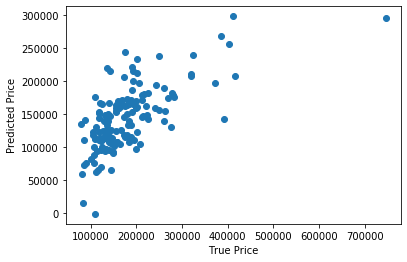

In [368]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')